# Python Function Comment Generator

By Derek Lilienthal and Dante Moon

### Defining the Problem

Code commentary is a very common task in computer science, but is often overlooked. Uncommented code can be frustrating to work with and it can be very time intensive to read through and understand. Through deep learning, there exists an opportunnity to develop more effective tools to quickly parse and comment code, thus reducing the amount of time and effort necessary to understand. 

One approach to helping solve this problem consists of using a sequence-to-sequence model with an encoder-decoder architecture in order to bridge the gap between Python syntax and English comments.

#### Measure of success

To have a deep learning model generate an English comment on a Python function that is representative of the logic in the function itself. We will be comparing the actual comments generated vs the comments generated by our models. Because this is a generative problem, we have to judge the problem using qualitative analysis instead of quantitative. There is not a firm metric that can be used to judge how well the model actually performs in our problem. 

Link to datasets used in the project: <br> 
https://github.com/github/CodeSearchNet <br>
https://www.kaggle.com/linkanjarad/coding-problems-and-solution-python-code?select=ProblemSolutionPythonV3.csv <br>
https://www.kaggle.com/veeralakrishna/python-code-data <br>

### Layout of the project
- Data Exploration and Pre-processing
- Baseline model
- Intermediate model
- Best model
- Conclusion

In [1]:
!pip install pysbd
!pip install langdetect
!pip install Keras==2.6.*

     |████████████████████████████████| 71 kB 13.7 MB/s            
     |████████████████████████████████| 981 kB 39.8 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=013808cd74e83c30612750c40e3cb880e76853f6f76401d20f7b94b385a027ac
  Stored in directory: /home/datalore/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect
     |████████████████████████████████| 1.3 MB 46.5 MB/s            
  Attempting uninstall: Keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [2]:
#imports
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool
import re
import pysbd # For sentence segmentation
from langdetect import detect_langs
import random
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Flatten, Dense, Embedding, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, Input
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from IPython.display import Image

## Data Exploration and Pre-processing

#### About the Data
We used three different datasets for this project, two sourced from Kaggle and one provided by Github.

The first two are a collection of different coding challenges from various sources such as w3resource, geeksforgeeks, etc. In these examples, there is usually a prompt written in plain English as well as a solution written in python code. The covered topics for the coding challenges include:
* Working with strings, lists, arrays, tuples, dictionaries, CSV, JSON
* Utilizing modules including NumPy, BeautifulSoup, tkinter, Pandas, random, os, re, datetime
* File I/O
* Loops and Conditionals
* Functions (including Lambda) and Classes
* OOP and DSA
* Searching & Sorting
* Pattern Printing 

Between these two datasets there are around 8000 examples of code and the matching prompt.

Our third dataset is CodeSearchNet by Github. The full dataset contains 2 million comment and code pairs across multiple programming languages, but we will only be using a selection of those written in python for our purposes here. CodeSearchNet was originally intended to help improve code searching using natural language but should work well for the problem of code summarization as well. The codenet data contains more advanced functions, class definitions, and is inherently more complex than the coding challenge data. 


#### Preprocessing Coding Challenge Data 
*Loading in the data from directory*

In [3]:
#reading in the data
# https://www.kaggle.com/linkanjarad/coding-problems-and-solution-python-code?select=ProblemSolutionPythonV3.csv
df = pd.read_csv("Data/ProblemSolutionPythonV3.csv") #small dataset 1
# https://www.kaggle.com/veeralakrishna/python-code-data
with open('Data/Python_code_data.txt') as f: #small dataset 2
    lines = f.readlines()
f.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3307 non-null   int64 
 1   Problem      3307 non-null   object
 2   Python Code  3306 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


#### Exploring a few samples from both datasets

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Problem,Python Code
0,Write a NumPy program to repeat elements of an...,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,Write a Python function to create and print a ...,def printValues():\n\tl = list()\n\tfor i in r...
2,Write a Python program to remove duplicates fr...,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,Write a NumPy program to compute the x and y c...,import numpy as np\rimport matplotlib.pyplot a...
4,Write a Python program to alter a given SQLite...,import sqlite3\rfrom sqlite3 import Error\rdef...


In [5]:
#reads in the file as a list of lines
lines[0:8]

['# write a python program to add two numbers \n',
 'num1 = 1.5\n',
 'num2 = 6.3\n',
 'sum = num1 + num2\n',
 "print(f'Sum: {sum}')\n",
 '\n',
 '\n',
 '# write a python function to add two user provided numbers and return the sum\n']

#### Cleaning Coding Challenge Data

Removing unnecessary language from the prompts, we do not need phrases like 'write a python function', 'write a numpy program', etc.

In [6]:
#remove the first few words from the prompt 'write a python program' 'write a python function' ... etc
df['Problem']=df['Problem'].apply(lambda x: ' '.join(x.split()[5:]))

In [7]:
#explore df
df.head()

,Problem,Python Code
0,repeat elements of an array.,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,create and print a list where the values are s...,def printValues():\n\tl = list()\n\tfor i in r...
2,remove duplicates from a list of lists.,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,compute the x and y coordinates for points on ...,import numpy as np\rimport matplotlib.pyplot a...
4,alter a given SQLite table.,import sqlite3\rfrom sqlite3 import Error\rdef...


For the second dataset, it was provided as a txt file so we needed to identify what lines are code and what lines are the problem prompts/comments.

In [8]:
#keep track of what lines in .txt file are used for comments, two lists that will eventually become the dataframe for 
#holding the prompt and holding the code
comments = []
comment_lines = []
code = []

In [9]:
#for each line, if it starts with a '#' character, save that line as a comment line
for i in np.arange(len(lines)):
    if(lines[i][0]=='#'):
        comments.append(lines[i])
        comment_lines.append(i)

In [10]:
#testing to see which lines are comment lines
print(comment_lines[0:4])
print(lines[0])
print(lines[7])

[0, 7, 13, 27]
# write a python program to add two numbers 

# write a python function to add two user provided numbers and return the sum



In [11]:
#populate list of code
for index, elem in enumerate(comment_lines):
    if index+1 < len(comment_lines) and index - 1 >= 0:
        prev = comment_lines[index-1]
        code.append(lines[prev+1:elem])

In [12]:
#create dataframe
df1 = pd.DataFrame(list(zip(comments,code)),columns=['comments','code'])

In [13]:
#convert list of lines to one string
df1['code'] = df1['code'].apply(lambda x: ' '.join(x))

In [14]:
df1.head()

,comments,code
0,# write a python program to add two numbers \n,num1 = 1.5\n num2 = 6.3\n sum = num1 + num2\n ...
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = n..."
2,# write a program to find and print the larges...,\n num1 = 10\n num2 = 12\n num3 = 14\n if (num...
3,# write a program to find and print the smalle...,num1 = 10\n num2 = 12\n num3 = 14\n if (num1 <...
4,# Write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\..."


The second dataset was less organized so we have a bunch of different manual rules to clean the problem prompts and remove examples that could not be cleaned.

In [15]:
#cleaning df1
df1['comments'] = df1['comments'].str.lower()
count = 0
remaining = 0
for row in df1['comments']:
    if len(df1['comments'][count].split())<=3: #removes lines that only have two words
        df1['comments'][count] = ''
    df1['comments'][count] = df1['comments'][count].replace('# write a python program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# write program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# write a ','')
    df1['comments'][count] = df1['comments'][count].replace('# write python code to demonstrate ','')
    df1['comments'][count] = df1['comments'][count].replace('# write python3 code to demonstrate','')
    df1['comments'][count] = df1['comments'][count].replace('# please write a program which ','')
    df1['comments'][count] = df1['comments'][count].replace('# please write a program to ','')
    df1['comments'][count] = df1['comments'][count].replace('# define a function that can ','')
    df1['comments'][count] = df1['comments'][count].replace('# define a function which can ','')
    if df1['comments'][count].find('write a program to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('write a program to')+19:]
    if df1['comments'][count].find('write a python program that')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('write a python program that')+28:]
    if df1['comments'][count].find('function to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function to')+12:]
    if df1['comments'][count].find('program to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('program to')+11:]
    if df1['comments'][count].find('define')!=-1 and df1['comments'][count].find('class')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('# in[')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('printing result')!=-1:
        df1['comments'][count] = ""
    if df1['comments'][count].find('code to')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('code to')+8:]
    if df1['comments'][count].find('function that')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function that')+14:]
    if df1['comments'][count].find('function which')!=-1:
        df1['comments'][count] = df1['comments'][count][df1['comments'][count].find('function which')+15:]
    if df1['comments'][count].find('#')==0:
        remaining+=1
    count+=1
print(df1.shape[0]-remaining,'clean examples')
print(remaining, 'remaining')
print(round(((df1.shape[0]-remaining)/df1.shape[0])*100,2) ,'% clean')

4111 clean examples
845 remaining
82.95 % clean


In [16]:
#replace empty prompts with null and then drop
df1['comments'].replace('', np.nan, inplace=True)
print(df1['comments'].isna().sum())
df1 = df1.dropna()
print(df1['comments'].isna().sum())
print(df1.shape)

365
0
(4591, 2)


In [17]:
#drop the remaining examples
df1 = df1[df1['comments'].str.find('#')==-1]
print(df1.shape)

(3735, 2)


In [18]:
df1.head()

,comments,code
0,add two numbers \n,num1 = 1.5\n num2 = 6.3\n sum = num1 + num2\n ...
1,add two user provided numbers and return the s...,"def add_two_numbers(num1, num2):\n sum = n..."
2,find and print the largest among three numbers\n,\n num1 = 10\n num2 = 12\n num3 = 14\n if (num...
3,find and print the smallest among three numbers\n,num1 = 10\n num2 = 12\n num3 = 14\n if (num1 <...
4,merge two given lists into one\n,"def merge_lists(l1, l2):\n return l1 + l2\..."


Now that we have both datasets processed we can combine them:

In [19]:
print(df1.columns)
print(df.columns)
df1.rename(columns={'comments':'Problem','code':'Python Code'},inplace=True)
print(df1.columns)

Index(['comments', 'code'], dtype='object')
Index(['Problem', 'Python Code'], dtype='object')
Index(['Problem', 'Python Code'], dtype='object')


In [20]:
df = df.append(df1)
df.shape

(7042, 2)

In [21]:
#lowercase everything
df['Problem']=df['Problem'].apply(lambda x: str(x).lower())
df['Python Code']=df['Python Code'].apply(lambda x: str(x).lower())

#### Preprocessing the CodeNet dataset

*Loading in data from directory*

In [22]:
data_dir = './Data'

In [23]:
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData.csv'))
codenet.head()

,docstring,function
0,Trains a k-nearest neighbors classifier for fa...,"def train(train_dir, model_save_path=None, n_n..."
1,Recognizes faces in given image using a traine...,"def predict(X_img_path, knn_clf=None, model_pa..."
2,Shows the face recognition results visually.\n...,"def show_prediction_labels_on_image(img_path, ..."
3,Convert a dlib 'rect' object to a plain tuple ...,"def _rect_to_css(rect):\n """"""\n Convert ..."
4,"Make sure a tuple in (top, right, bottom, left...","def _trim_css_to_bounds(css, image_shape):\n ..."


Size of the dataset

In [24]:
codenet.shape

(503502, 2)

**Exploring some random samples**

*Click the cell below multiple times for different examples*

In [25]:
rand_example = np.random.choice(codenet.shape[0])
print("#"*120 + "\n" + "#"*22, "-"*30, " Docstring  ", "-"*30, "#"*22 + "\n" + "#"*120, '\n')
print(codenet['docstring'].iloc[rand_example])
print('\n' + "#"*120 + "\n" + "#"*22, "-"*30, "  Function  ", "-"*30, "#"*22 + "\n" + "#"*120, '\n')
print(codenet['function'].iloc[rand_example])

########################################################################################################################
###################### ------------------------------  Docstring   ------------------------------ ######################
######################################################################################################################## 

Receives HTTP request and negotiates up to a Websocket session

########################################################################################################################
###################### ------------------------------   Function   ------------------------------ ######################
######################################################################################################################## 

async def handler(self, request):
        """
        Receives HTTP request and negotiates up to a Websocket session
        """

        def task_done(future):
            self.tasks.remove(future)
       

#### Steps for cleaning the docstrings and functions

**Docstring** <br>
1. Remove the line breaks
2. Remove the tabs
3. Remove the examples that starts with `return`, `Args`, `:param`, or `Parameters`
4. Remove the examples that are in another language
5. Remove the examples that contain more characters than just a `,` or `.` (No extra characters)
6. Remove `,` from examples 
7. Lowercase everything
8. Remove everything after the first sentence
9. Remove the period after the end of the sentence
10. Remove examples that are less than 3 words and more than 20
11. Remove any missing or blank examples

**Function** <br>
1. Remove everything between triple quotes
2. Remove functions that have more than 100 words or so
3. Remove any tabs, line breaks, extra white spaces and add spacing between commas, parentheses, and equal signs
5. Remove any missing or blank examples

*Note: running the code below can take a long time to process the data (45+ minutes sometimes). You can skip all the pre-processing steps and load in the cleaned data below. The step that takes this long is using the language detection (step 4) to remove any examples that are not in English on 500k+ examples. Even multi-threading this operations takes around 10 minutes on 14 cores.*

In [26]:
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

**Cleaning docstring**

In [27]:
# ### Step 1
# codenet['docstring_cleaned'] = codenet['docstring'].apply(lambda x: str(x).split('\n\n')[0])

# ### Step 2
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ' '.join(str(x).replace('\n',' ').split()))

# ### Step 3
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find(':return:') == -1 else str(x).find(':return:'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find('Args') == -1 else str(x).find('Args'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find(':param') == -1 else str(x).find(':param'))])
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: x[:(None if str(x).find('Parameters') == -1 else str(x).find('Parameters'))])

# ### Step 4
# def detectEnglish(input):
#     try:
#         if(detect_langs(input)[0].lang=="en"):
#             return True
#         else: 
#             return False
#     except:
#         return False

# def add_features(df):       
#     df['docstring_isEnglish'] = df['docstring'].apply(lambda x: detectEnglish(str(x)))
#     return df

# def parallelize_dataframe(df, func, n_cores=8):
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

# codenet = parallelize_dataframe(codenet, add_features, n_cores=14) # Multi-threading 
# codenet = codenet[codenet['docstring_isEnglish'] == True]
# codenet = codenet.reset_index(drop=True) # reseting the index

# ### Step 5
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: x.replace(' ','').replace(',','').replace('.','').isalpha())]
# codenet = codenet.reset_index(drop=True)

# ### Step 6
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).replace(',',''))

# ### Step 7
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).lower())

# ### Step 8
# seg = pysbd.Segmenter(language="en", clean=False)
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: seg.segment(x)[0])

# ### Step 9
# codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: str(x).rstrip('.'))

# ### Step 10
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: len(x.split()) > 2)]
# codenet = codenet[codenet['docstring_cleaned'].apply(lambda x: len(x.split()) < 21)]

# ### Step 11
# codenet = codenet[codenet['docstring_cleaned'].astype(str) != ''] # Removing any docstrings that are empty
# codenet = codenet[codenet['docstring_cleaned'].isna() == False]
# codenet = codenet[codenet["docstring_cleaned"].astype(str) != 'None']
# codenet = codenet.reset_index(drop=True) # reseting the index

*Looking at the cleaned examples now*

In [28]:
rand_example = np.random.choice(codenet.shape[0])
print(f'Cleaned docstring: {codenet["docstring_cleaned"].iloc[rand_example]}\n')
print(f'Old docstring: {codenet["docstring"].iloc[rand_example]}')

Cleaned docstring: mark one event channel as non exported in database

Old docstring: Mark one event channel as non exported in database

        :param argin: name of event channel or factory to unexport
        :type: tango.DevString
        :return: none
        :rtype: tango.DevVoid


**Cleaning Functions**

In [29]:
# ### Step 1
# def remove_pydocs_doubleQ(text):
#     text = str(text)
#     try:
#         indexes_to_remove = []
#         for match in re.finditer('"""', text):
#             indexes_to_remove.append(match.start())  
#         return text[:indexes_to_remove[0]] + text[indexes_to_remove[1]+3:]
#     except:
#         pass
    
# codenet['function_cleaned'] = codenet['function'].apply(remove_pydocs_doubleQ)

# ### Step 2
# codenet = codenet[codenet['function_cleaned'].apply(lambda x: len(str(x).split())) < 101]

# ### Step 3
# def clean_function(text):
#     text_split = str(text).replace('\n',' ').replace('\t',' ').replace(',', ' , ').split()
#     text = ' '.join(text_split)
#     text = (text.replace('(', ' ( ').replace(')', ' ) ')
#             .replace('=',' = ').replace('"', ' " ')
#             .replace("'", " ' ").replace("#"," # ")
#             .replace('[',' [ ').replace(']', ' ] ')
#             .replace('{',' { ').replace('}', ' } ')
#             .replace(':', ' : ').replace('  ',' '))
#     return text

# codenet['function_cleaned'] = codenet['function_cleaned'].apply(clean_function)

# ### Step 4
# codenet = codenet[codenet['function_cleaned'].astype(str) != ''] # Removing any functions that are empty
# codenet = codenet[codenet['function_cleaned'].isna() == False] 
# codenet = codenet[codenet["function_cleaned"].astype(str) != 'None']
# codenet = codenet.reset_index(drop=True) # reseting the index

*Looking at the cleaned functions*

In [30]:
rand_example = np.random.choice(codenet.shape[0])
print(f'Cleaned function: \n{codenet["function_cleaned"].iloc[rand_example]}\n')
print(f'Old function: \n{codenet["function"].iloc[rand_example]}')

Cleaned function: 
def get_db_prep_save ( self , value ) : if not value : return super ( JSONField , self ) .get_db_prep_save ( " " ) else : return super ( JSONField , self ) .get_db_prep_save ( dumps ( value ) ) 

Old function: 
def get_db_prep_save(self, value):
        """ Convert our JSON object to a string before we save """
        if not value:
            return super(JSONField, self).get_db_prep_save("")
        else:
            return super(JSONField, self).get_db_prep_save(dumps(value))


New shape of the pre-processed dataset

In [31]:
codenet.shape

(201624, 4)

In [32]:
codenet.head()

,docstring,docstring_cleaned,function,function_cleaned
0,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def _raw_face_locations(img, number_of_times_t...","def _raw_face_locations ( img , number_of_time..."
1,Returns an array of bounding boxes of human fa...,returns an array of bounding boxes of human fa...,"def face_locations(img, number_of_times_to_ups...","def face_locations ( img , number_of_times_to_..."
2,Return the Catalyst datatype from the size of ...,return the catalyst datatype from the size of ...,"def _int_size_to_type(size):\n """"""\n Ret...",def _int_size_to_type ( size ) : if size < = 8...
3,Convert a schema from Spark to Arrow,convert a schema from spark to arrow,"def to_arrow_schema(schema):\n """""" Convert ...",def to_arrow_schema ( schema ) : import pyarro...
4,Convert schema from Arrow to Spark.,convert schema from arrow to spark,"def from_arrow_schema(arrow_schema):\n """""" ...",def from_arrow_schema ( arrow_schema ) : retur...


*Removing any hiddle characters*

In [33]:
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

In [34]:
# ### Saving the dataset to the data dir
# codenet[['docstring','docstring_cleaned','function','function_cleaned']].to_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv')

## Baseline model

This model mirrors a similar structure as the language translation notebook provided by Chollet. We selected this approach because it served as a good starting point that we could implement fairly quickly.

Create a list of code and comment pairs for the input and then print a random selection from that list.

In [35]:
code_pairs = []
for row in df.iterrows():
    code_pairs.append((row[1][1],'[start] '+row[1][0]+' [end]'))

In [36]:
#print a random pair of code and prompt
print(random.choice(code_pairs))

('from itertools import groupby\rdef modified_encode(alist):\r        def ctr_ele(el):\r            if len(el)>1: return [len(el), el[0]]\r            else: return el[0]\r        return [ctr_ele(list(group)) for key, group in groupby(alist)]\r\rn_list = [1,1,2,3,4,4,5, 1]\rprint("original list:") \rprint(n_list)\rprint("\\nlist reflecting the modified run-length encoding from the said list:")\rprint(modified_encode(n_list))\r\rn_list = \'aabcddddadnss\'\rprint("\\noriginal string:") \rprint(n_list)\rprint("\\nlist reflecting the modified run-length encoding from the said string:")\rprint(modified_encode(n_list))\r\r', '[start] create a list reflecting the modified run-length encoding from a given list of integers or a given list of characters. [end]')


Set up training, validation, and test data and display the total number of pairs:

In [37]:
random.shuffle(code_pairs)
num_validation_samples = int(0.15 * len(code_pairs))
num_training_samples = len(code_pairs) - 2 * num_validation_samples

train = code_pairs[:num_training_samples]
val = code_pairs[num_training_samples:num_training_samples + num_validation_samples]
test = code_pairs[num_training_samples + num_validation_samples:]
print(len(train) + len(val) + len(test), 'total pairs')

7042 total pairs


Next up, we need to calculate the size of the vocabulary using the built in Tokenizer from Keras.

This works by splitting up each of the possible words found in the dataset and counting how many unique words are present.

In [38]:
#figure out size of the vocabulary
tokenizer = Tokenizer()
full_text = df['Python Code'].tolist()
full_text.extend(df['Problem'].tolist())
tokenizer.fit_on_texts(full_text)
vocab_size = len(tokenizer.word_index)+1
print('vocabulary size: ',vocab_size)

vocabulary size:  13473


Now that we have the vocabulary size figured out, we need to determine how many words our output sequences should be. 

First lets calculate how many words are present for each of the problem prompts and add that as a column to the dataframe:

In [39]:
#figure out the output sequence length
df['word_count_problem']=df['Problem'].apply(lambda x: len(str(x).split()))

We want the sequence length to be appropriate for the largest amount of data without being too long, so we will select the 90th percentile value as our sequence length.

In [40]:
sequence_length = int(df.word_count_problem.quantile(0.90))
print('90th percentile length of the prompt: ',sequence_length)

90th percentile length of the prompt:  17


In [41]:
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)

Fit each of the vectorization layers to their respective data, one for the code snippets and one for comments:

In [42]:
train_code_texts = [pair[0] for pair in train]
train_comments_texts = [pair[1] for pair in train]
source_vectorization.adapt(train_code_texts)
target_vectorization.adapt(train_comments_texts)

**Further preparation of data for the model**

In [43]:
batch_size = 32 

def format_dataset(code, comment):
    """This function converts the code and comments into one-hot encoded vectors"""
    code = source_vectorization(code)
    comment = target_vectorization(comment)
    return ({
        "code": code, # Original one-hot encoding
        "comment": comment[:, :-1], # Comment without the end-token
    }, comment[:, 1:]) # Comment without the start-token

def make_dataset(pairs):
    """This function converts the raw-text pairs into a tensorflow dataset. Similar to pandas and numpy."""
    code_texts, comment_texts = zip(*pairs) 
    code_texts = list(code_texts) 
    comment_texts = list(comment_texts) 
    dataset = tf.data.Dataset.from_tensor_slices((code_texts, comment_texts)) # combine both sets of data into a tensorflow dataset
    dataset = dataset.batch(batch_size) # Converts the dataset 32 examples at a time
    dataset = dataset.map(format_dataset, num_parallel_calls=4) # Uses 4 parallel processes
    return dataset.shuffle(2048).prefetch(16).cache() 
    
train_dataset = make_dataset(train)
val_dataset = make_dataset(val)

#### Model Architecture

According to a blog post from the TensorFlow team, they recommend embedding dimension should be set to the fourth root of your embedding vector (vocab_size in this case). However, in this example, that works out to be 11 and in execution, using too few embedding dimensions yielded higher loss and less accurate results 

In [44]:
round(vocab_size**0.25)

11

In the translation problem Chollet had a vocabulary size of 15,000 and used an embedding dimension of 256 and latent dimension of 1024, because our vocab size is similar, we will just keep the same values. 

In [45]:
embed_dim = 256
latent_dim = 1024  
 
source = layers.Input(shape=(None,), dtype="int64", name="code") # Input layer for functions
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source) # Embedding layer for functions
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x) # Bidirecitonal GRU (Encoder)

past_target = layers.Input(shape=(None,), dtype="int64", name="comment") # Input layer for comments
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target) # Embedding layer for comments
decoder_gru = layers.GRU(latent_dim, return_sequences=True) # GRU (decoder)
x = decoder_gru(x, initial_state=encoded_source) # Initializing the states of the decoder with the encoders states
x = layers.Dropout(0.5)(x) # Regularization
target_next_step = layers.Dense(vocab_size, activation="softmax")(x) # Output softmax probabilities of each token  
seq2seq_rnn = tf.keras.Model([source, past_target], target_next_step) 

In [46]:
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
code (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
comment (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    3449088     code[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3449088     comment[0][0]                    
______________________________________________________________________________________________

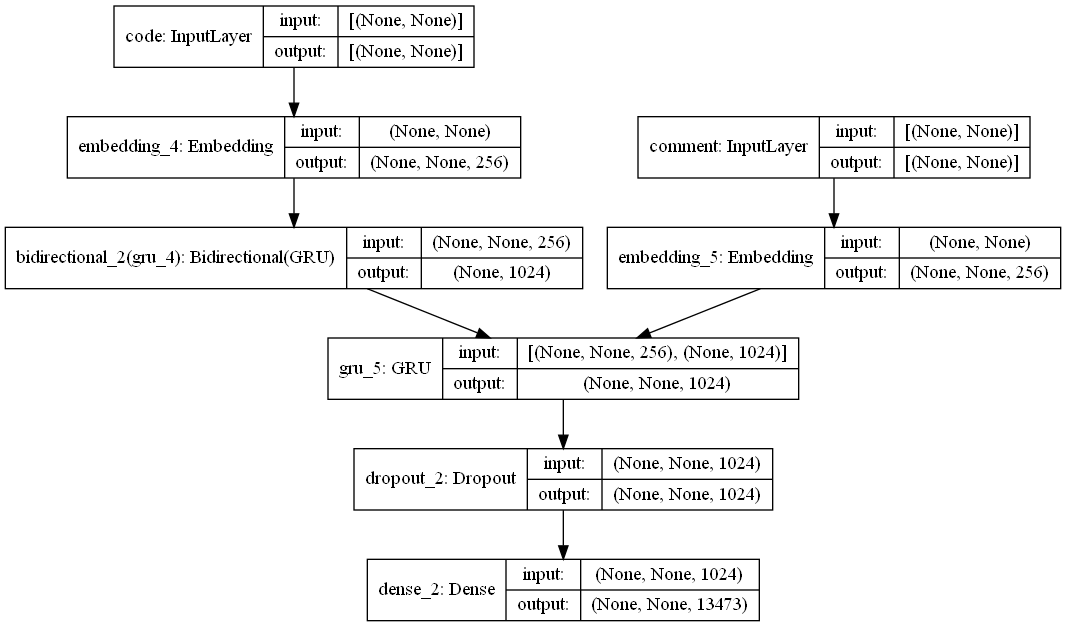

In [48]:
#keras.utils.plot_model(seq2seq_rnn, show_shapes=True)
Image(filename='./pics/seq2seq model.png')

In [49]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [50]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = seq2seq_rnn.fit(train_dataset, epochs=30, validation_data=val_dataset,callbacks=[callback])

Epoch 1/30
155/155 [==============================] - 23s 82ms/step - loss: 3.0080 - accuracy: 0.2458 - val_loss: 2.5897 - val_accuracy: 0.3138
Epoch 2/30
155/155 [==============================] - 10s 63ms/step - loss: 2.4179 - accuracy: 0.3412 - val_loss: 2.3782 - val_accuracy: 0.3548
Epoch 3/30
155/155 [==============================] - 10s 63ms/step - loss: 2.1919 - accuracy: 0.3866 - val_loss: 2.2489 - val_accuracy: 0.3866
Epoch 4/30
155/155 [==============================] - 10s 63ms/step - loss: 2.0129 - accuracy: 0.4264 - val_loss: 2.1304 - val_accuracy: 0.4147
Epoch 5/30
155/155 [==============================] - 10s 63ms/step - loss: 1.8453 - accuracy: 0.4629 - val_loss: 2.0375 - val_accuracy: 0.4366
Epoch 6/30
155/155 [==============================] - 10s 63ms/step - loss: 1.6942 - accuracy: 0.5027 - val_loss: 1.9740 - val_accuracy: 0.4558
Epoch 7/30
155/155 [==============================] - 10s 64ms/step - loss: 1.5459 - accuracy: 0.5410 - val_loss: 1.9118 - val_accuracy:

In [51]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

The model begins to overfit early and trains for 21 epochs before the early stopping callback for validation loss.

Later on we will explore the relationship between overfitting and the accuracy of our results, but for now this may be in part due to the amount of data we have. This model is only trained on a portion of the two smaller datasets.

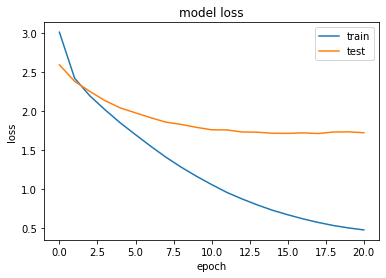

In [52]:
plot_metric(history)

This is the decoding function in order to translate the sequences back into plain text

In [53]:
comment_vocab = target_vectorization.get_vocabulary()            
comment_index_lookup = dict(zip(range(len(comment_vocab)), comment_vocab))   
max_decoded_sentence_length = sequence_length
 
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[predicted]"                           
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(        
            [tokenized_input_sentence, tokenized_target_sentence])   
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = comment_index_lookup[sampled_token_index]         
        decoded_sentence += " " + sampled_token                  
        if sampled_token == "end":          
            break
    return decoded_sentence

Below are 20 random examples taken from the test data with the code, actual comment, and the predicted comment

In [54]:
test_code_texts = [pair[0] for pair in test] 
for _ in range(20):
    random_index = random.randrange(len(test_code_texts))
    input_sentence = test_code_texts[random_index]
    actual = test[random_index][1]
    #input_sentence = random.choice(test_code_texts)
    print("-")
    print(input_sentence)
    print('[actual] ',actual)
    print(decode_sequence(input_sentence))

-
n = 20
 number_list = [ x for x in range(n) if x % 2 == 0]
 print(f'list of even numbers:', number_list)
 
 

[actual]  [start] list comprehension in python to get a list of even numbers when a range is given 
 [end]
[predicted] list of numbers in the list of integers end
-
  
 list1 = [11, 5, 17, 18, 23, 50]  
   
 for ele in list1: 
     if ele % 2 == 0: 
         list1.remove(ele) 
   
 print("new list after removing all even numbers: ", list1) 
 

[actual]  [start] remove even numbers from a list. print the final list.
 [end]
[predicted] remove even numbers from a list end
-
# opening both the files in reading modes
with open("file1.txt") as f1, open("file2.txt") as f2:
    
  # reading f1 contents
  line1 = f1.readline()
    
  # reading f2 contents
  line2 = f2.readline()
    
  # printing contents of f1 followed by f2 
  print(line1, line2)
[actual]  [start] together in python [end]
[predicted] in python class to print all possible characters in the string end
-
def nth_sq_and

**Testing the model on the CodeNet dataset**

In [55]:
### Helper function to make a nicer function print
def rem_double_q(input):
    loc1 = input.find('\"\"\"')
    loc2 = input.find('\"\"\"',loc1+3)
    return input[:loc1]+input[loc2+3:]

example = np.random.choice(np.arange(codenet.shape[0]))
print("Actual Comment:", ' '.join(codenet['docstring_cleaned'].iloc[example].split()[1:-1]))
print()
print(decode_sequence(codenet['docstring_cleaned'].iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].iloc[example])}")

Actual Comment: the identifier from an item depending on its

[predicted] count of the key of a given string end

Test Function:
def metadata_id(item):
        

        if Crates.metadata_category(item) == CATEGORY_CRATES:
            return str(item['id'])
        else:
            ts = item['fetched_on']
            ts = str_to_datetime(ts)
            return str(ts.timestamp())


Even though our first model does really well on the simple functions, it does not perform well on more complex functions. Like the ones in the CodeNet dataset.

## Intermediate model

For the intermediate model, we will now be moving over to the CodeNet dataset because the CodeNet dataset is more complex than the previous two datasets. We will also be using a slightly different architecture by utilizing the `RepeatVector` and `TimeDistrubuted` layers to help us achieve an encoder-decoder model.

**Preprocessing each comment to have a unique start (\<starttoken\>) and stop (\<endtoken\>) token** <br>
This is needed in order for the model to generate consistent predictions

In [56]:
### Reading in the data to have a fresh start
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

### Removing any hidden characters
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: '<starttoken> '+ x.strip() +' <endtoken>')
codenet.head()

,docstring,docstring_cleaned,function,function_cleaned
0,Returns an array of bounding boxes of human fa...,<starttoken> returns an array of bounding boxe...,"def _raw_face_locations(img, number_of_times_t...","def _raw_face_locations ( img , number_of_time..."
1,Returns an array of bounding boxes of human fa...,<starttoken> returns an array of bounding boxe...,"def face_locations(img, number_of_times_to_ups...","def face_locations ( img , number_of_times_to_..."
2,Return the Catalyst datatype from the size of ...,<starttoken> return the catalyst datatype from...,"def _int_size_to_type(size):\n """"""\n Ret...",def _int_size_to_type ( size ) : if size < = 8...
3,Convert a schema from Spark to Arrow,<starttoken> convert a schema from spark to ar...,"def to_arrow_schema(schema):\n """""" Convert ...",def to_arrow_schema ( schema ) : import pyarro...
4,Convert schema from Arrow to Spark.,<starttoken> convert schema from arrow to spar...,"def from_arrow_schema(arrow_schema):\n """""" ...",def from_arrow_schema ( arrow_schema ) : retur...


**Splitting the up the functions by . and _** <br>
This allows us to have less unique tokens to choose from. 

In [57]:
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('.',' . '))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ' '.join(x.split()))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.lower())
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('_',' _ '))

**Splitting the data into a training and validation set**

We are doing 5,000 testing examples and 150,000 training examples for this model

In [58]:
### Splitting the data into a training a validation set
X_train, X_test, y_train, y_test = train_test_split(codenet['function_cleaned'], codenet['docstring_cleaned'], test_size=5000, train_size=150000, random_state=41)

*Looking at the number of unqiue tokens in the training set*

In [59]:
### Creating a tokenizer for all the function tokens 
function_tokenizer = keras.preprocessing.text.Tokenizer(filters='')

### Fitting them to every value
function_tokenizer.fit_on_texts(X_train.values)
function_word_index = function_tokenizer.word_index
print(f"There are {len(function_word_index)} unique tokens in the training set of functions")

There are 166936 unique tokens in the training set of functions


**Preparing the input data for the Encoder**

Below we use the keras TextVectorizaiton layer to create our list of vocab words and their indexes. The TextVectorization allows us to get the top *n* most common words as our vocab instead of encoding each unique vocab word directly. This is an improvement over the previous ways of encoding text data by using the keras Tokenizer, and pad_sequences.

In [60]:
MAX_FUNCTION_LEN = 100
MAX_FUNCTION_WORDS = 100000

# One-hot encode the data
encoder_vectorizer = TextVectorization(
    standardize=None,
    max_tokens=MAX_FUNCTION_WORDS,
    output_mode='int',
    output_sequence_length=MAX_FUNCTION_LEN)
encoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train.tolist())) 

# Encode the training data to a vector by creating a model to do it for us
encoder_vectorize_model = Sequential()
encoder_vectorize_model.add(Input(shape=(None,), dtype=tf.string))
encoder_vectorize_model.add(encoder_vectorizer)
encoder_input_data = encoder_vectorize_model.predict([X_train])

# Save the vocabulary as a dictionary
function_word_index = dict(zip(encoder_vectorizer.get_vocabulary(), np.arange(MAX_FUNCTION_WORDS)))
NUM_FUNCTION_WORDS = len(function_word_index)
print(f'Found {NUM_FUNCTION_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {encoder_input_data.shape}')

Found 100000 unique function word tokens
Encoder input data shape -> (150000, 100)


**Preparing the data for the decoder**

We created two seperate vocabularies instead of a single vocabulary list because we found that when we combined both, we would get comments generated where the model would predict an unknown token *[UNK]* fairly often. But when we forced the model to predict on the vocabulary of only the comments, we would no longer get comments containing *[UNK]*. 

In [61]:
MAX_COMMENT_LEN = 17 # 15 actual word plus start and stop tokens

# One-hot encode the data
decoder_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=None,
    output_mode='int',
    output_sequence_length=MAX_COMMENT_LEN)
decoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(y_train.tolist())) 

# Encode the training data to a vector
decoder_vectorize_model = Sequential()
decoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
decoder_vectorize_model.add(decoder_vectorizer)
decoder_input_data = decoder_vectorize_model.predict([y_train])

comment_word_index = dict(zip(decoder_vectorizer.get_vocabulary(), np.arange(len(decoder_vectorizer.get_vocabulary()))))
NUM_COMMENT_WORDS = len(comment_word_index)
print(f'Found {NUM_COMMENT_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {decoder_input_data.shape}')

Found 31158 unique function word tokens
Encoder input data shape -> (150000, 17)


*Reverse dictionary of the comments. This will be helpful for decoding the predictions*

In [62]:
reverse_comment_word_index = {v: k for k, v in comment_word_index.items()}

#### Model Architecture

We don't take credit for coming up with the design of this model. We followed this architecture from this blog and modified it to fit our problem set. <br>
https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b

In [63]:
input_sequence = Input(shape=(MAX_FUNCTION_LEN,))
embedding = Embedding(input_dim=MAX_FUNCTION_WORDS, output_dim=512, mask_zero=True)(input_sequence)
encoder = LSTM(256, return_sequences=False)(embedding)

### Takes in an input vector and repeates it 'n' amount of times
r_vec = RepeatVector(MAX_COMMENT_LEN)(encoder) 

decoder = LSTM(256, return_sequences=True)(r_vec)

### Applies the same Dense layer over the 'n' number of unique tokens
output_sequence = TimeDistributed(Dense(NUM_COMMENT_WORDS, activation="softmax"))(decoder) 

enc_dec_model = Model(input_sequence, output_sequence)
enc_dec_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam')
enc_dec_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 512)          51200000  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 17, 31158)         8007606   
Total params: 60,520,374
Trainable params: 60,520,374
Non-trainable params: 0
_______________________________________________

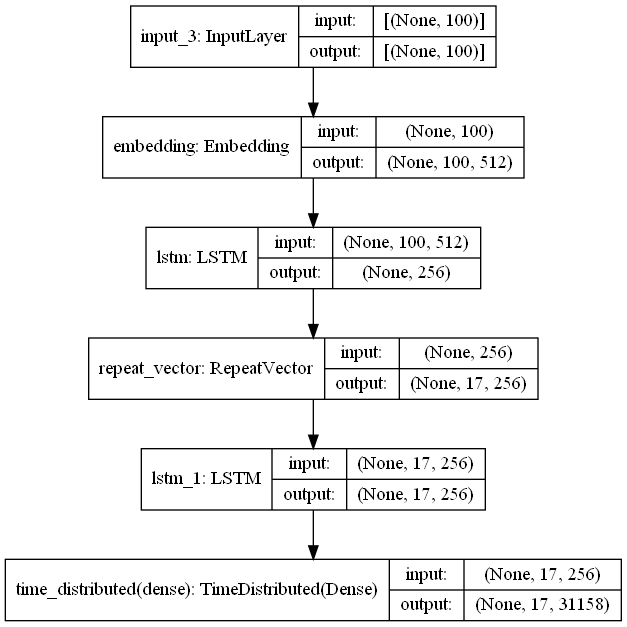

In [64]:
#keras.utils.plot_model(enc_dec_model, show_shapes=True)
Image(filename='./pics/Intermediate Model Arc.png')

**Training the model**

In [65]:
# history = enc_dec_model.fit(encoder_input_data, 
#                             decoder_input_data, 
#                             batch_size=512, 
#                             epochs=10, 
#                             validation_split=0.2, callbacks=[early_stopping])

*This is what the EPOCHS looked like during training*

Epoch 1/10 <br>
235/235 [==============================] - 61s 224ms/step - loss: 4.4460 - val_loss: 3.8865 <br>
Epoch 2/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.6765 - val_loss: 3.5241 <br>
Epoch 3/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.4829 - val_loss: 3.4612 <br>
Epoch 4/10 <br>
235/235 [==============================] - 52s 221ms/step - loss: 3.4744 - val_loss: 3.4176 <br>
Epoch 5/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.3958 - val_loss: 3.3878 <br>
Epoch 6/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.3493 - val_loss: 3.3549 <br>
Epoch 7/10 <br>
235/235 [==============================] - 52s 223ms/step - loss: 3.3025 - val_loss: 3.3599 <br>
Epoch 8/10 <br>
235/235 [==============================] - 52s 222ms/step - loss: 3.2585 - val_loss: 3.3255 <br>
Epoch 9/10 <br>
235/235 [==============================] - 53s 226ms/step - loss: 3.2118 - val_loss: 3.3252 <br>
Epoch 10/10 <br>
235/235 [==============================] - 52s 223ms/step - loss: 3.1642 - val_loss: 3.3300 <br>

In [66]:
def plot_history(history):
    """This function plots the training and validation loss"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))

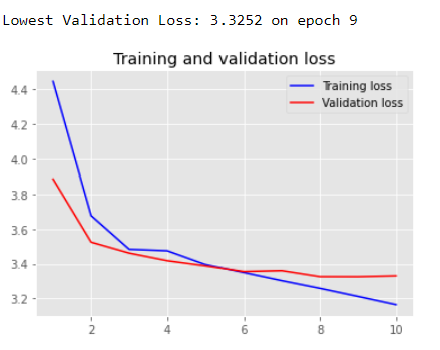

In [67]:
#plot_history(history)
Image(filename='./pics/Intermediate Model Training Graph.png')

*Loading the model instead of training it*

In [68]:
# history = enc_dec_model.fit(encoder_input_data, 
#                             decoder_input_data, 
#                             batch_size=512, 
#                             epochs=10, 
#                             validation_split=0.2, callbacks=[early_stopping])

enc_dec_model = tf.keras.models.load_model('saved_models/middle_encoder.h5')

**Making inferences**

In [69]:
def make_inferences(text):
    """
    This function takes in a python function that has been pre-processed and 
    generates a comment based on the models prediction
    """
    text_encoding = encoder_vectorize_model.predict([text])
    prediction = enc_dec_model.predict(text_encoding)
    
    output = ''
    
    for index in np.argmax(prediction[0], 1):
        if index == 2: # Start word
            continue
        # If the last word is the same as the predicted word or the current word is end
        if index == 3 or (len(output.split()) > 1 and 
                          str(output.split()[-1]) == str(reverse_comment_word_index[index])): 
            break
        output += ' ' + str(reverse_comment_word_index[index])
    return output

**Testing on the training data**

In [70]:
example = np.random.choice(np.arange(X_train.shape[0]))
print("Actual Comment:", ' '.join(y_train.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_train.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_train.index[example]])}")

Actual Comment: attempts to remove a child from the ad group.

Predicted Comments:  return the

Test Function:
def remove_child(self, group_lookup_attribute_value):
        

        remove_child = {'member': (MODIFY_DELETE, [self._get_group_dn(group_lookup_attribute_value)])}
        self._attempt_modification("child", group_lookup_attribute_value, remove_child)


**Testing on data it's never seen before**

In [71]:
example = np.random.choice(np.arange(X_test.shape[0]))
print("Actual Comment:", ' '.join(y_test.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_test.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_test.index[example]])}")

Actual Comment: draws the bezier component

Predicted Comments:  create the to of

Test Function:
def _draw_mainlayer(self, gc, view_bounds=None, mode="default"):
        

        if not self.points: return
        gc.save_state()
        try:
            gc.set_fill_color(self.pen.fill_color_)

            gc.set_line_width(self.pen.line_width)
            gc.set_stroke_color(self.pen.color_)

            gc.begin_path()
            start_x, start_y = self.points[0]
            gc.move_to(start_x, start_y)
            for triple in nsplit(self.points[1:], 3):
                x1, y1 = triple[0]
                x2, y2 = triple[1]
                end_x, end_y = triple[2]
                gc.curve_to(x1, y1, x2, y2, end_x, end_y)
                # One point overlap
                gc.move_to(end_x, end_y)
            gc.stroke_path()
        finally:
            gc.restore_state()


**Testing on the first dataset**

In [72]:
example = np.random.choice(np.arange(df.shape[0]))
print("Actual Comment:", ' '.join(df['Problem'].iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(df['Problem'].iloc[example]))
print()
print(f"Test Function:\n{df['Python Code'].iloc[example]}")

Actual Comment: sum of nested list using

Predicted Comments:  return the to

Test Function:
total = 0
 def sum_nestedlist(l):
     global total
     for j in range(len(l)):
         if type(l[j]) == list:
 
             sum_nestedlist(l[j])
         else:
             total += l[j]
 
 sum_nestedlist([[1, 2, 3], [4, [5, 6]], 7])
 print(total)
 



As we can see, this model is not performing nearly as well as the previous one even though we trained it on 150k examples. We believe this is due to large the number of unique tokens (functions 100k, comments 31k) the model has to learn and make predictions with. Our data is too sparse to make reasonable predictions. This is evident in the high training and validation loss compared to the previous model before over-fitting (3.3 vs 1.8). Our next model will break up the tokens of the CodeNet model even further and select an even smaller amount of tokens.

## Best performing model

Our best performing model is most similar to the first model, where we have two embedding spaces (one for comments and functions) and an RNN to do sequence-to-sequence generate. However, now we have two different size embedding spaces (50k for functions and 31k for comments) and used LSTM's instead. We also further pre-processed the CodeNet data to prevent as many unique tokens in both the comments and functions. 

Some of the architecture for this model came from <br>
https://keras.io/examples/nlp/lstm_seq2seq/ <br>
https://colab.research.google.com/drive/11os3isH4I4X76dwOAQJ5cSRnfhmUziHm#scrollTo=2Mfco9WKukhS.

*Below is the same pre-processing steps as the previous model*

In [73]:
### Reading in the data to have a fresh start
codenet = pd.read_csv(os.path.join(data_dir, 'CodeNetData_cleaned.csv'))

codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))
codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: ''.join(line for line in x if line in string.printable))

codenet['docstring_cleaned'] = codenet['docstring_cleaned'].apply(lambda x: '<start> '+ x.strip() +' <end>')

codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('.',' . '))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: ' '.join(x.split()))
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.lower())
codenet['function_cleaned'] = codenet['function_cleaned'].apply(lambda x: x.replace('_',' _ '))

Because this model is more complex than the previous two models, we are not able to use all the data and can only train on 20,000 examples. This is partly due to the size of the embedding layers for both the functions and the comments themselves.

In [74]:
### Splitting the data into a training a validation set
X_train, X_val, y_train, y_val = train_test_split(codenet['function_cleaned'], codenet['docstring_cleaned'], 
                                                  test_size=5000, train_size=20000, random_state=41)

*Taking a look at how many unique tokens there are in the functions*

In [75]:
### Creating a tokenizer for all the function tokens 
function_tokenizer = keras.preprocessing.text.Tokenizer(filters='')

### Fitting them to every value
function_tokenizer.fit_on_texts(X_train.values)
function_word_index = function_tokenizer.word_index
NUM_FUNCTION_WORDS = len(function_word_index)
NUM_FUNCTION_WORDS

43619

**Preparing the input data for the Encoder**

In [76]:
MAX_FUNCTION_LEN = 100
MAX_FUNCTION_WORDS = 20000

# One-hot encode the data
encoder_vectorizer = TextVectorization(
    standardize=None,
    max_tokens=MAX_FUNCTION_WORDS,
    output_mode='int',
    output_sequence_length=MAX_FUNCTION_LEN)
encoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train.tolist())) 

# Encode the training data to a vector
encoder_vectorize_model = Sequential()
encoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
encoder_vectorize_model.add(encoder_vectorizer)
encoder_input_data = encoder_vectorize_model.predict([X_train])

function_word_index = dict(zip(encoder_vectorizer.get_vocabulary(), np.arange(MAX_FUNCTION_WORDS)))
NUM_FUNCTION_WORDS = len(function_word_index)
print(f'Found {NUM_FUNCTION_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {encoder_input_data.shape}')

Found 20000 unique function word tokens
Encoder input data shape -> (20000, 100)


**Prepairing the input data for the Decoder**

In [77]:
MAX_COMMENT_LEN = 15
MAX_COMMENT_WORDS = 5000

# One-hot encode the data
decoder_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=None,
    output_mode='int',
    output_sequence_length=MAX_COMMENT_LEN)
decoder_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(y_train.tolist())) 

# Encode the training data to a vector
decoder_vectorize_model = Sequential()
decoder_vectorize_model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
decoder_vectorize_model.add(decoder_vectorizer)
decoder_input_data = decoder_vectorize_model.predict([y_train])

comment_word_index = dict(zip(decoder_vectorizer.get_vocabulary(), np.arange(len(decoder_vectorizer.get_vocabulary()))))
NUM_COMMENT_WORDS = len(comment_word_index)
print(f'Found {NUM_COMMENT_WORDS} unique function word tokens')

print(f'Encoder input data shape -> {decoder_input_data.shape}')

Found 11068 unique function word tokens
Encoder input data shape -> (20000, 15)


**Preparing the target data for the Decoder**<br>

The step needed to prepare the data for decoding is to remove the [starttoken] tab and then re-convert the responses to one-hot vectors. We do this so the decoder learned to predict everything after the first token and not the first token itself, all the way to the [endtoken] position. We one-hot encode the decoder data in order for us to get the index of the highest probability for our word in the comment index.

In [78]:
decoder_target_data = list()
for token_seq in decoder_input_data:
    decoder_target_data.append( token_seq[1: ] ) # Removing the [Start] 
    
padded_y_train_lines = keras.preprocessing.sequence.pad_sequences(decoder_target_data, maxlen=MAX_COMMENT_LEN, padding='post' )
decoder_target_data = keras.utils.to_categorical(padded_y_train_lines, NUM_COMMENT_WORDS) 
print( 'Decoder target data shape -> {}'.format(decoder_target_data.shape))

Decoder target data shape -> (20000, 15, 11068)


In [79]:
print('There are {} examples. \nFor each example there are {} words\nFor each word there are {} possible words to choose from'.format(decoder_target_data.shape[0], decoder_target_data.shape[1], decoder_target_data.shape[2]))

There are 20000 examples. 
For each example there are 15 words
For each word there are 11068 possible words to choose from


In [81]:
# Create a reverse word index dict for turning numbers back into sentences
reverse_comment_word_index = {v: k for k, v in comment_word_index.items()}

**Model Design**

In [82]:
tf.keras.backend.clear_session()

EMBEDDING_DIM = 256
RNN_CELLS = 128

### ENCODER ###
encoder_inputs = layers.Input(shape=(None, ), name='Encoder Input (Functions)') # Allow for variable input lengths
encoder_embedding = layers.Embedding(input_dim=NUM_FUNCTION_WORDS, 
                                     output_dim=EMBEDDING_DIM, 
                                     mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = layers.LSTM(RNN_CELLS, return_state=True)(encoder_embedding)
encoder_states = [ state_h , state_c ] # Saving the states to add to the decoder

### DECODER ###
decoder_inputs = layers.Input(shape=(None, ), name='Decoder Input (Comments)')
decoder_embedding = tf.keras.layers.Embedding(input_dim=NUM_COMMENT_WORDS, 
                                              output_dim=EMBEDDING_DIM, 
                                              mask_zero=True)(decoder_inputs)
decoder_lstm = layers.LSTM(RNN_CELLS, return_state=True, return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm(decoder_embedding, initial_state=encoder_states ) # Adding the encoder states to the lstm decoder
decoder_dense = layers.Dense(NUM_COMMENT_WORDS, activation='softmax') 
output = decoder_dense(decoder_outputs)

### Joining together
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder Input (Functions) (Inpu [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder Input (Comments) (Input [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    5120000     Encoder Input (Functions)[0][0]  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2833408     Decoder Input (Comments)[0][0]   
______________________________________________________________________________________________

After creating the model, we can load in the weights instead of re-training.

In [83]:
model.load_weights(tf.train.latest_checkpoint('saved_weights/short_epochs'))

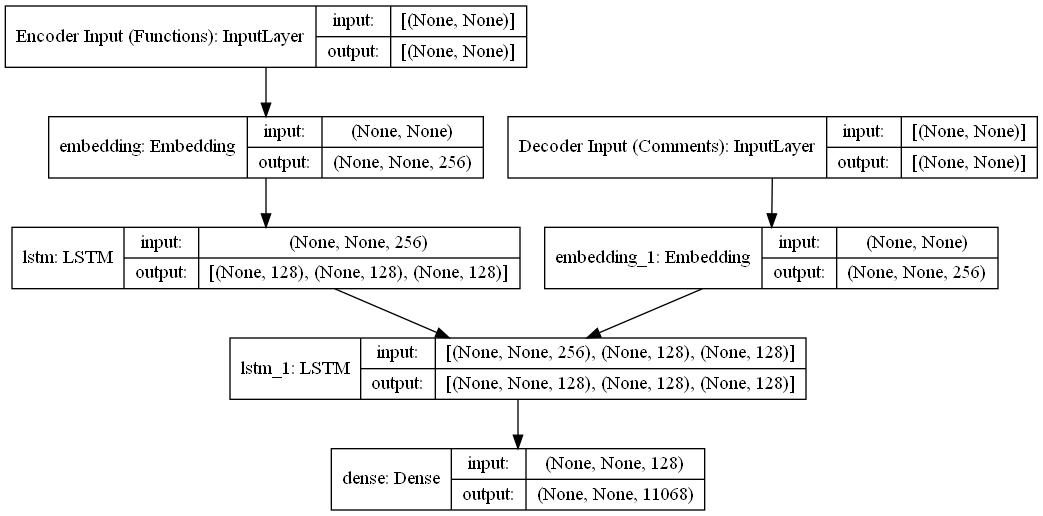

In [18]:
#keras.utils.plot_model(model, show_shapes=True)
Image(filename='./pics/Full Encoder.png')

In [84]:
# history = model.fit([encoder_input_data, decoder_input_data], 
#                     decoder_target_data,  
#                     epochs=50, 
#                     batch_size=32,
#                     validation_split=0.2)

Epoch 1/50 <br>
500/500 [==============================] - 20s 32ms/step - loss: 3.6440 - val_loss: 3.2847<br>
Epoch 2/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 3.1462 - val_loss: 3.1728<br>
Epoch 3/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 3.0114 - val_loss: 3.1276<br>
Epoch 4/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.9093 - val_loss: 3.1054<br>
Epoch 5/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.8183 - val_loss: 3.0912<br>
Epoch 6/50<br>
500/500 [==============================] - 13s 25ms/step - loss: 2.7278 - val_loss: 3.0855<br>
Epoch 7/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.6345 - val_loss: 3.0902<br>
Epoch 8/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.5419 - val_loss: 3.0972<br>
Epoch 9/50<br>
500/500 [==============================] - 13s 26ms/step - loss: 2.4527 - val_loss: 3.1222<br>

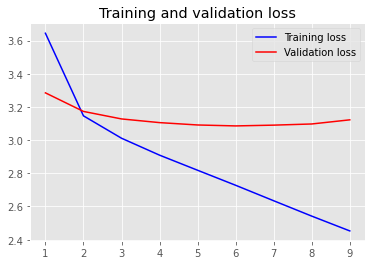

In [85]:
#plot_history(history)
Image(filename='./pics/Best Model Short Epochs.png')

In order for us to be able to make inferences, we need to create a new model from our trained model.

For the **encoder model**:
 - Input
  - Inputs of the encoder (functions that have been tokenized)
  - Trained encoder states 
 - Output
  - The state of the predicted function

For the **decoder model**: 
 - Input
  - Hidden (memmory) state of encoder model
  - Cell (carry) state of encoder model
 - Output
  - A softmax output of index in of the next word. Based on the index in the comment dictionary

In [86]:
def make_inference_models():
    
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=(RNN_CELLS ,), name='Hidden state')
    decoder_state_input_c = tf.keras.layers.Input(shape=(RNN_CELLS ,), name='Cell state')
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

enc_model, dec_model = make_inference_models()

*Looking at the Encoder*

In [87]:
enc_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder Input (Functions) (I [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 197120    
Total params: 5,317,120
Trainable params: 5,317,120
Non-trainable params: 0
_________________________________________________________________


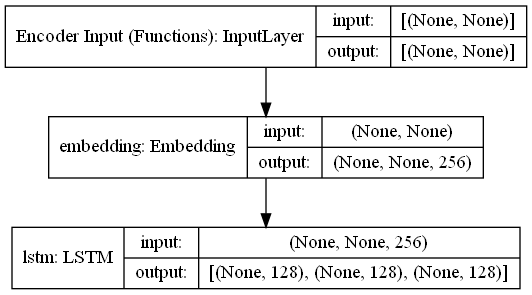

In [88]:
#keras.utils.plot_model(enc_model, show_shapes=True)
Image(filename='./pics/Encoder1.png')

*Looking at the Decoder*

In [89]:
dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder Input (Comments) (Input [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2833408     Decoder Input (Comments)[0][0]   
__________________________________________________________________________________________________
Hidden state (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
Cell state (InputLayer)         [(None, 128)]        0                                            
____________________________________________________________________________________________

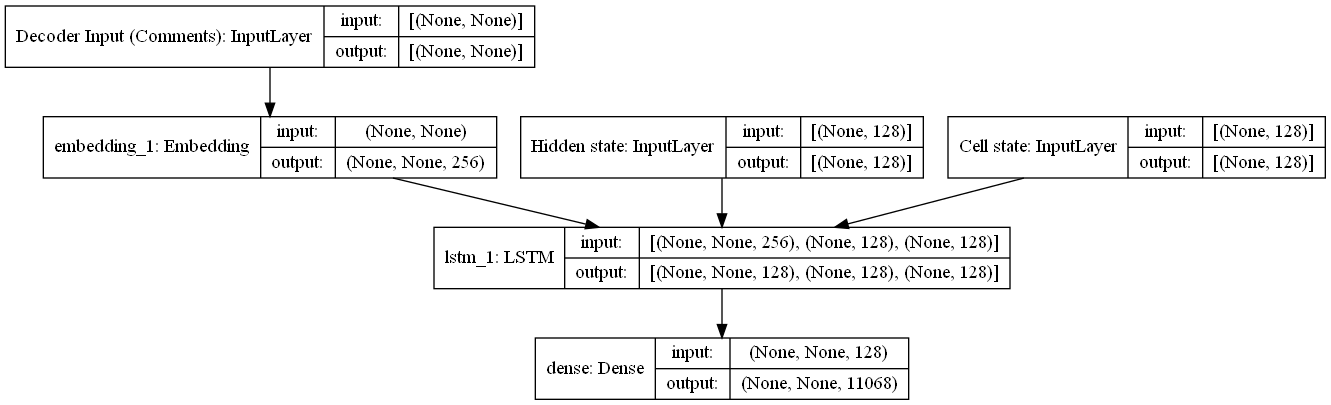

In [90]:
#keras.utils.plot_model(dec_model, show_shapes=True)
Image(filename='./pics/Decoder1.png')

**Making inferences**

In [91]:
# Helper function
def str_to_tokens( sentence : str ):
    """This function will pre-processed a cleaned function for predictions"""
    return encoder_vectorize_model.predict([sentence])

def rem_double_q(input):
    loc1 = input.find('\"\"\"')
    loc2 = input.find('\"\"\"',loc1+3)
    return input[:loc1]+input[loc2+3:]

def make_inferences(function: str):
    test_output = str_to_tokens(function)    
    
    # Predict the starting state values with the input 
    states_values = enc_model.predict( test_output )
    # Create a blank array to store the predictions
    empty_target_seq = np.zeros((1, 1))
    # Populate the predictions by including the starting token (1)
    empty_target_seq[0, 0] = comment_word_index['start']

    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        # Make a prediction given the previous word and the state values
        dec_outputs, h, c = dec_model.predict([ empty_target_seq ] + states_values )
        
        # Get the index of the word by getting the highest probability of the index predicted by the decoder model 
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )

        # Adding the word to the response
        sampled_word = None
        for word, index in comment_word_index.items():
            if sampled_word_index == index:
                decoded_translation += ' {}'.format( word )
                sampled_word = word

        # If we reach our stop word, the length of the comment is more than 20, or the last word is repeated
        if sampled_word == 'end' or len(decoded_translation.split()) > 20:
            stop_condition = True
            
        if len(decoded_translation.split()) > 1 and decoded_translation.split()[-1] == decoded_translation.split()[-2]:
            return ' '.join(decoded_translation.split()[:-2]).strip()

        # Reset the target sequence with the last predicted word as the starting point
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        # Reset the state values to the last state predicted by the decoder
        states_values = [ h , c ] 
    
    # Return the prediction as a string
    return ' '.join(decoded_translation.split()[:-1]).strip()

**Testing on the training data**

In [92]:
example = np.random.choice(np.arange(X_train.shape[0]))
print("Actual Comment:", ' '.join(y_train.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_train.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_train.index[example]])}")

Actual Comment: apply transformation and dependencies and fix new node location

Predicted Comments: create a new instance of the current state of the given

Test Function:
def run(self, node):
        
        n = super(Transformation, self).run(node)
        if self.update:
            ast.fix_missing_locations(n)
            self.passmanager._cache.clear()
        return n


**Testing on data never seen before**

In [93]:
example = np.random.choice(np.arange(X_val.shape[0]))
print(example)
print("Actual Comment:", ' '.join(y_val.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_val.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_val.index[example]])}")

980
Actual Comment: scores each feature with the algorithm and ranks them in a bar plot

Predicted Comments: create a new instance of the given a list of the same of the

Test Function:
def rank1d(X, y=None, ax=None, algorithm='shapiro', features=None,
           orient='h', show_feature_names=True, **kwargs):
    
    # Instantiate the visualizer
    visualizer = Rank1D(ax, algorithm, features, orient, show_feature_names,
                        **kwargs)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X, y, **kwargs)
    visualizer.transform(X)

    # Return the axes object on the visualizer
    return visualizer.ax


### Re-training best model to sevearly overfit

An interesting observation that we noticed is when we overfit the model. We actually got a lot better comments generated compared to stopping when looking at the validation loss.

Loading in the weights of the sevearly overfit model

In [94]:
model.load_weights(tf.train.latest_checkpoint('saved_weights/long_epochs'))

*Training plot of re-trained overfit model*

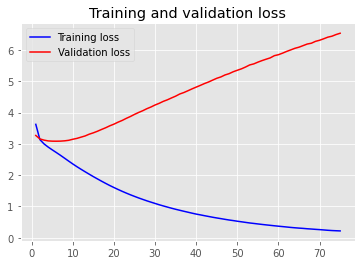

In [95]:
Image(filename='./pics/Best Model Long Epochs.png')

**Testing on data it's never seen before**

In [96]:
example = np.random.choice(np.arange(X_val.shape[0]))
print(example)
print("Actual Comment:", ' '.join(y_val.iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(X_val.iloc[example]))
print()
print(f"Test Function:\n{rem_double_q(codenet['function'].loc[y_val.index[example]])}")

1146
Actual Comment: initialize content of these metadata

Predicted Comments: initializes the creation of the event

Test Function:
def __init__(self):
        
        self.data = list()
        self._fields = ('data',)
        super(Metadata, self).__init__()


**Testing on the first dataset**

In [100]:
def clean_function(text):
    """This function processes a python function to prepare for inferences"""
    text_split = str(text).replace('\n',' ').replace('\t',' ').replace(',', ' , ').split()
    text = ' '.join(text_split)
    text = (text.replace('(', ' ( ').replace(')', ' ) ')
            .replace('=',' = ').replace('"', ' " ')
            .replace("'", " ' ").replace("#"," # ")
            .replace('[',' [ ').replace(']', ' ] ')
            .replace('{',' { ').replace('}', ' } ')
            .replace(':', ' : ').replace('  ',' '))
    return text    

In [104]:
example = np.random.choice(np.arange(df.shape[0]))
print("Actual Comment:", ' '.join(df['Problem'].iloc[example].split()[1:-1]))
print()
print("Predicted Comments:", make_inferences(clean_function(df['Problem'].iloc[example])))
print()
print(f"Test Function:\n{df['Python Code'].iloc[example]}")

Actual Comment: the values of two given

Predicted Comments: return the secondary mass and symmetric of word

Test Function:
print(result)


As we can see above, the model is not perfect. It gives better results th

### Passing your own function to make predictions on

In [105]:
actual_function = '''
def sum(num1, num2):
    return num1 + num2
'''

test_example = clean_function(actual_function)

print("Predicted Comments:", make_inferences(test_example))
print()
print(f"Test Function:\n{actual_function}")

Predicted Comments: destroy this index

Test Function:

def sum(num1, num2):
    return num1 + num2



## Conclusion

In this notebook, we implemented three different encoder-decoder models that were all slightly different from each other. The first model was trained on a simpler and smaller dataset while the last two models were trained on a more complex dataset. The first model gave decent results generating comments on its validation set but did not generate good comments on the complex dataset. The second model did not give good comments on either its validation set or the first dataset, but the model itself was trained on 150k examples, compared to just 7k with the previous model. Finally, the last model was trained only on a smaller subset of CodeNet data (20k examples). This model performed better than the middle model but not as great as the first model... Until we allowed the model to severely over fit. Then the last model predicted better comments on the CodeNet data but not that great on the first dataset. 

We think this phenomenon of the last model doing well on the CodeNet data but not well on the first dataset is because the CodeNet dataset is very complex and often has functions that were originally in Class files. Compared to the first dataset, which is programming challenges and coding tutorials. Because the last model was only trained on the complex functions, it doesn't do a good job generating comments on functions. And vice-versa when we tried to make predictions with the first model on the CodeNet data. Where it didn't perform well either. 

While the solution to this problem may have been fixed by combining both datasets together and training a new model on that data, we essentially ran out of time because we spent a lot of time experimenting, pre-processing the data, and running out of resources to train these models. 

**Things that we experimented with but didn't actually make it onto the notebook** <br>
For the first model, we experimented with:
- Using pre-trained word embeddings
    - GloVe and SpaCy but could not get this integrated effectively.
- Different model structure
    - Experimented with LSTM vs GRU, stacking more layers. 

For the best model, we experimented with 
- Using a pre-trained embedding layer for the comments.
    - This didn't work for some reason due to the way we were passing in data via the functional API method using tensorflow_hub. 
- Adding more RNN, Dense, and Regularization layers
    - Adding a more complexity to the model seemed to make for worse comment generations. We are not too sure why this was the case. 
- Allowing for larger and smaller comments and function lengths. 
    - We experimented with the size of both inputs and the length of sequence generations. We found that a comment generation size of 15 was optimal and an input size of 100 for functions captured the most of functions. We also found that the large the output sequence we made, the smaller the training and validation loss would get. We think this is because the model was correctly predicting everything after a certain amount of tokens as being empty/no comments. 